# Figure 2: Pressure

- Panel (a): RTN Magnetic Field [nT]
- Panel (b): Pressure [nPa]
- Panel (c): Total/Expected Pressure [nPa]
- Panel (d): Electron/Proton plasma Beta 

In [1]:
import glob
# import pyspedas
# from pyspedas import time_string, time_double
# from pytplot import tplot, get_data, cdf_to_tplot, store_data
import astrospice
import sunpy 
import sunpy.coordinates as scoords
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from scipy import stats


import sys, os
import datetime
import numpy as np
sys.path.append(os.path.realpath(''))
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

import utilities as utils
# import tools.sigma as sigma
# import tools.psp_funcs as psp_funcs
# import tools.pfss_funcs as pfss_funcs
# from tools.plotting import plot_pfss
# from tools.settings import CsvDir, ImgDir, PlotDir, DataDir
# import matplotlib.ticker as ticker


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from datetime import timedelta

# for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 

# REGIONS
loc_hcs = [61.5, 62.2]
loc_hcs1 = [357.7, 357.9]
ssw = [9, 19]
fsw = [42, 52]

# COLORS
scol, hcol, fcol, rcol = ['lavender', 'azure', 'lavenderblush', 'grey']
cc = ['lightpink', 'mediumspringgreen', 'peachpuff', 'powderblue', 'thistle', 'palegoldenrod']

# DIRECTORIES
FIG_DIR = os.path.realpath('figures')
EPS_DIR = os.path.realpath('eps_figures')
OBS_DIR = '/Users/tamarervin/products/csv_files/calcs/'
PlotDir = '/Users/tamarervin/mplstyle/'
RES_DIR = os.path.join('/Users/tamarervin/', 'e15_results')


# PLOT STYLING
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 20})
plt.style.use(plot_style)
plt.rcParams['axes.linewidth'] = 5

enc='E15'


## Read in Data

In [2]:
# ### READ IN DATA ###
parker, parkerdownt, parkerdownl, pss, orbiter, orbiterdownl, orbiterdownt, oss, wind, winddownt, winddownl, wss = utils.read_data(RES_DIR, sigma_time=20, pp='parker20.csv', pflag=True)

### DEFINE REGIONS ###
lon_footpoints = parker.sslon
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
hhcs1 = np.logical_and(lon_footpoints >= loc_hcs1[0], lon_footpoints <=loc_hcs1[1])
slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])
fast = np.logical_and(lon_footpoints >=fsw[0], lon_footpoints <=fsw[1])

# flagNe = np.logical_and(pd.Timestamp('2023-03-16 18:00:00')<=parker.Time, parker.Time<=pd.Timestamp('2023-03-17 00:00:00'))
# parker['Pe'][flagNe] = np.zeros(len(parker['Pe'][flagNe]))

/Users/tamarervin/publications/e15/utilities.py:186: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()
/Users/tamarervin/publications/e15/utilities.py:186: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()
/Users/tamarervin/publications/e15/utilities.py:195: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.

In [3]:
Rsun = (np.array(parker.rAU)*u.AU).to(u.Rsun)
parker['Ptotal'] = (parker.Pa + parker.Pp + parker.Pm + parker.Pe)/1e-9
parker['Pk'] = (parker.Pa + parker.Pp + parker.Pe)/1e-9
parker['Pap'] = (parker.Pa + parker.Pp)/1e-9

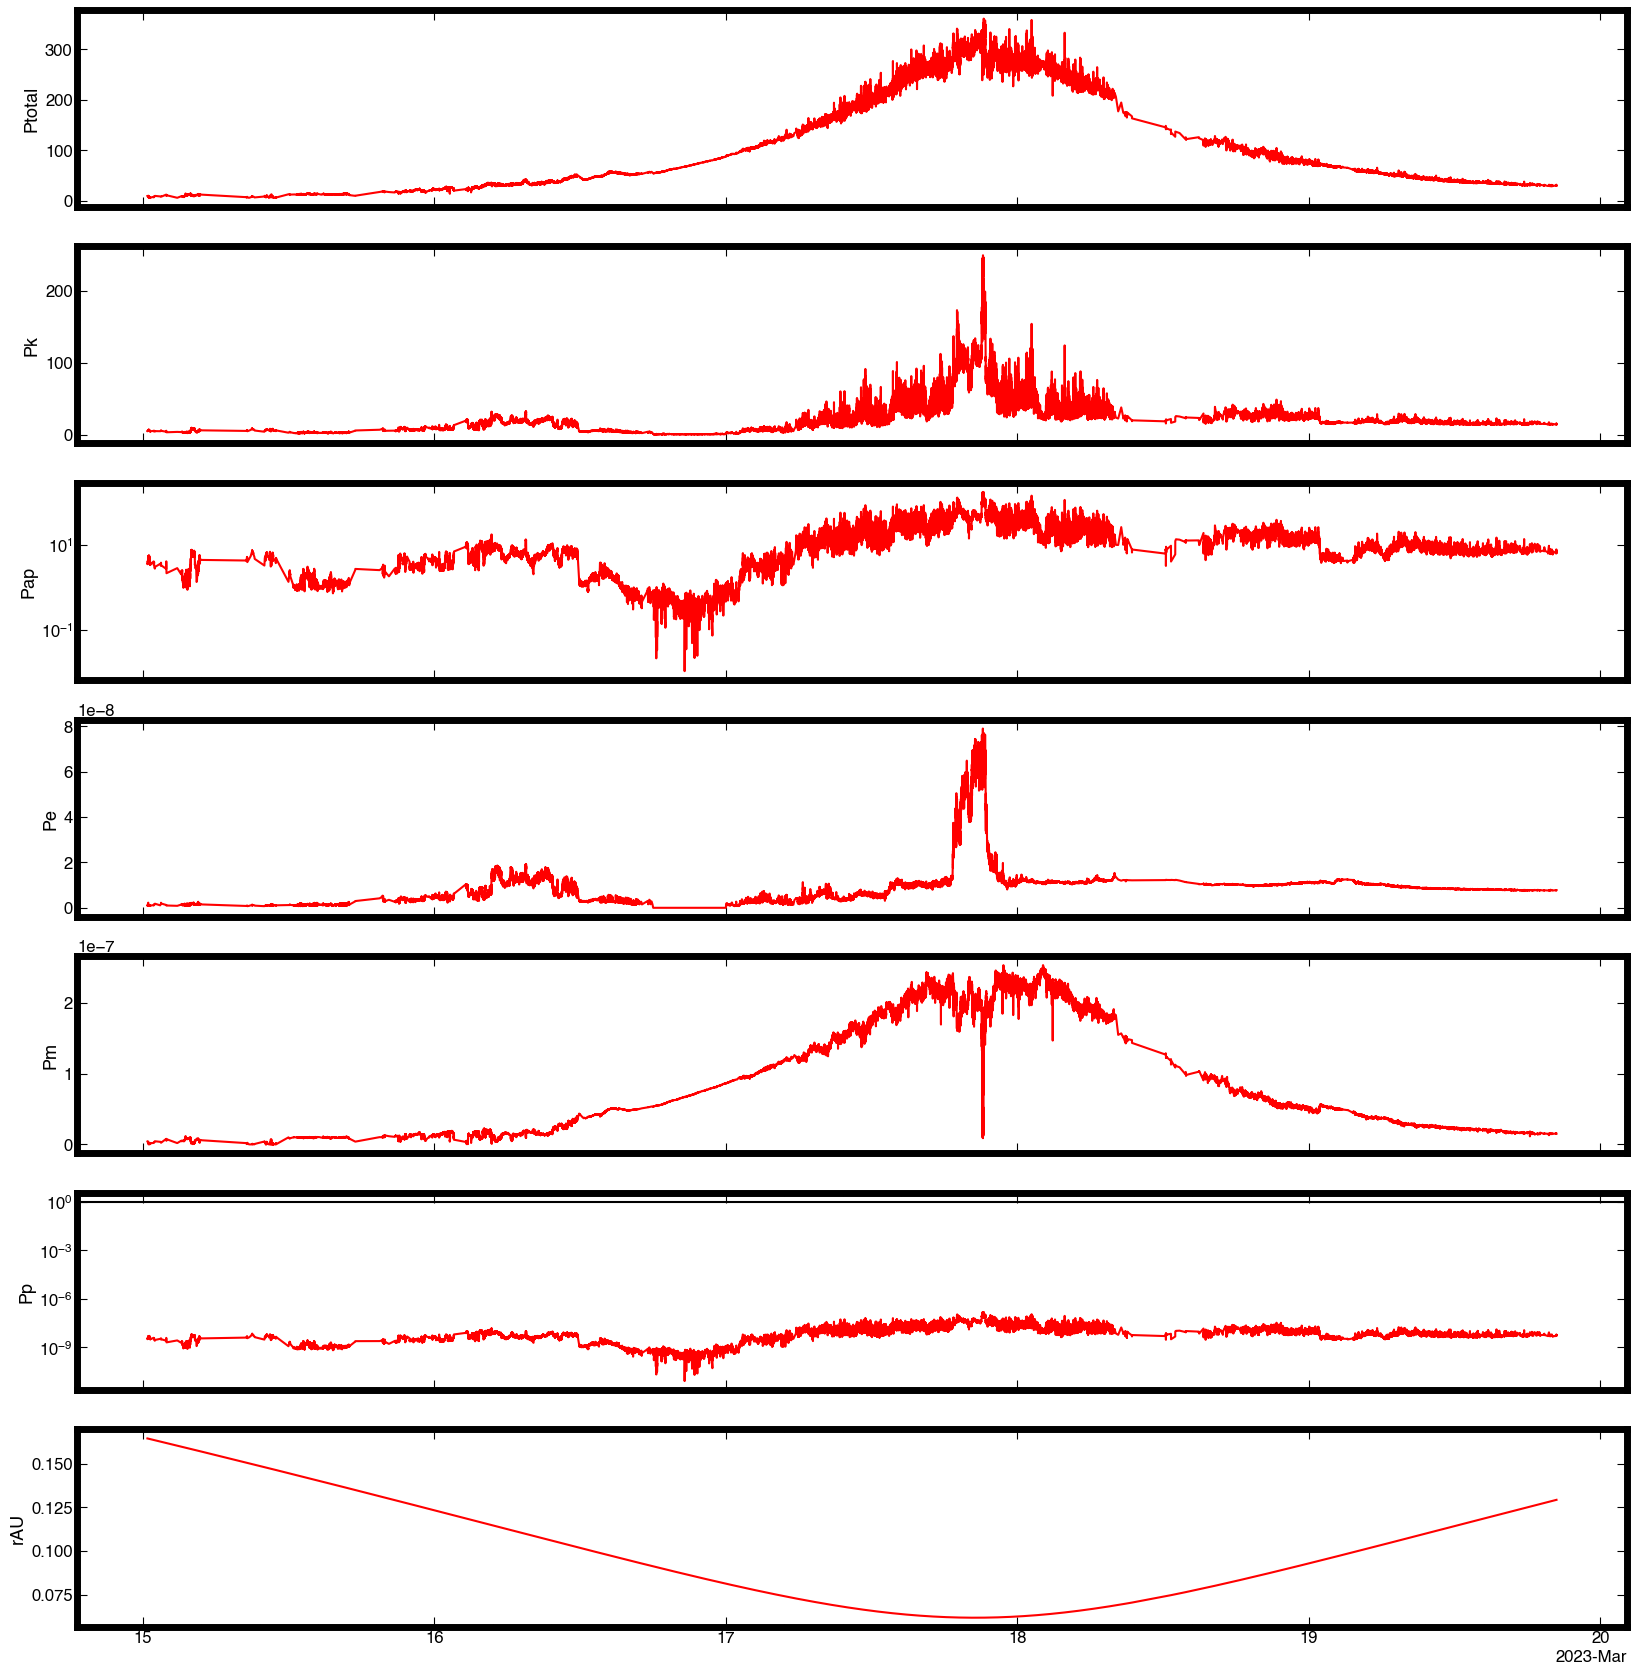

In [9]:
datas = ['Ptotal', 'Pk', 'Pap', 'Pe', 'Pm', 'Pp', 'rAU']
fig, axs = plt.subplots(len(datas), figsize=[20, len(datas)*3], sharex='all')

for i, vv in enumerate(datas):
    axs[i].plot(parker.Time, parker[vv], c='red')
    axs[i].set(ylabel=vv)
axs[-2].set_yscale('log')
axs[-2].axhline(1, c='k')
axs[2].set_yscale('log')

# FIT RADIAL PRESSURE

- except power-law index between -4 and -10/3
- since beta < 1 for period of interest, should be clsoer to -4

In [10]:
from scipy.optimize import curve_fit
from tabulate import tabulate

def linear_fit(x_data, y_data, initial_guess=(1.0)): #, parameter_bounds=([-4, 4], [-10/3, 8])):
    def model(x, m, b):
        return (10**b)*(x**m)

    # Fit the model
    params, covariance = curve_fit(model, x_data, y_data, p0=initial_guess)

    # Extract the fitted parameters
    m = params

    return m

initial_guess = (-3.31, 6.30)  

# Define the data and fits
data_names = ['Total', 'Magnetic', 'Kinetic', 'Alpha-Proton', 'Electron']
data_values = [parker.Ptotal, parker.Pm/1e-9, parker.Pk, parker.Pap, parker.Pe/1e-9]
fit_results = []

# Fit each data set and store the results
for data_name, data in zip(data_names, data_values):
    m = linear_fit(Rsun.value, data, initial_guess) #, parameter_bounds=([-5, 1], [-2, 16]))
    fit_results.append([data_name, m])

# Print the results as a table
print(tabulate(fit_results, headers=["Data", "Power-Law", "Coefficient"], tablefmt="pretty"))




06-Mar-24 15:51:40: /Users/tamarervin/anaconda3/envs/psp38/lib/python3.8/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)



+--------------+-----------------------------+
|     Data     |          Power-Law          |
+--------------+-----------------------------+
|    Total     |  [-3.73397804  6.64778791]  |
|   Magnetic   |  [-3.59968967  6.39660814]  |
|   Kinetic    | [-15.61962268  19.43668674] |
| Alpha-Proton | [-11.09723966  14.14804861] |
|   Electron   |  [-2.21657085  3.72520091]  |
+--------------+-----------------------------+


In [11]:
from scipy.optimize import curve_fit
from tabulate import tabulate

def linear_fit(x_data, y_data, initial_guess=(1.0)): #, parameter_bounds=([-4, 4], [-10/3, 8])):
    def model(x, m, b):
        return (10**b)*(x**m)

    # Fit the model
    params, covariance = curve_fit(model, x_data, y_data, p0=initial_guess)

    # Extract the fitted parameters
    m = params

    return m

initial_guess = (-3.31, 6.61)  

# Define the data and fits
data_names = ['Total', 'Magnetic', 'Kinetic', 'Alpha-Proton', 'Electron']
data_values = [parker.Ptotal[slow], parker.Pm[slow]/1e-9, parker.Pk[slow], parker.Pap[slow], parker.Pe[slow]/1e-9]
fit_results = []

# Fit each data set and store the results
for data_name, data in zip(data_names, data_values):
    m = linear_fit(Rsun.value[slow], data, initial_guess) #, parameter_bounds=([-5, 1], [-2, 16]))
    fit_results.append([data_name, m])

# Print the results as a table
print('coefficient values for sub-sonic region')
print(tabulate(fit_results, headers=["Data", "Power-Law"], tablefmt="pretty"))




coefficient values for sub-sonic region
+--------------+---------------------------+
|     Data     |         Power-Law         |
+--------------+---------------------------+
|    Total     | [-3.48339931  6.28094455] |
|   Magnetic   | [-3.50431593  6.28255319] |
|   Kinetic    | [-2.96936107  4.37840228] |
| Alpha-Proton | [-7.18544153  9.28803074] |
|   Electron   |  [0.11075915 0.2227467 ]  |
+--------------+---------------------------+


In [12]:
from scipy.optimize import curve_fit
from tabulate import tabulate

def linear_fit(x_data, y_data, initial_guess=(1.0, 0.0)): #, parameter_bounds=([-4, 4], [-10/3, 8])):
    def model(x, b):
        return (10**b)*(x**(-10/3))

    # Fit the model
    params, covariance = curve_fit(model, x_data, y_data, p0=initial_guess)

    # Extract the fitted parameters
    b = params

    return b[0]

initial_guess = (5.96)  

# Define the data and fits
data_names = ['Total', 'Magnetic', 'Kinetic', 'Alpha-Proton', 'Electron']
data_values = [parker.Ptotal, parker.Pm/1e-9, parker.Pk, parker.Pap, parker.Pe/1e-9]
fit_results = []

# Fit each data set and store the results
for data_name, data in zip(data_names, data_values):
    b = linear_fit(Rsun.value, data, initial_guess) #, parameter_bounds=([-5, 1], [-2, 16]))
    fit_results.append([data_name, b])

# Print the results as a table
print('Coefficient Values for', '$R^{-10/3}$')
print(tabulate(fit_results, headers=["Data", "Coefficient"], tablefmt="pretty"))




Coefficient Values for $R^{-10/3}$
+--------------+-------------------+
|     Data     |    Coefficient    |
+--------------+-------------------+
|    Total     | 6.188929920455014 |
|   Magnetic   | 6.091472838912859 |
|   Kinetic    | 5.492141324923628 |
| Alpha-Proton | 5.318877922760327 |
|   Electron   | 5.00930851020078  |
+--------------+-------------------+


In [13]:
from scipy.optimize import curve_fit
from tabulate import tabulate

def linear_fit(x_data, y_data, initial_guess=(1.0, 0.0)): #, parameter_bounds=([-4, 4], [-10/3, 8])):
    def model(x, b):
        return (10**b)*(x**(-4))

    # Fit the model
    params, covariance = curve_fit(model, x_data, y_data, p0=initial_guess)

    # Extract the fitted parameters
    b = params

    return b[0]

initial_guess = (5.96)  

# Define the data and fits
data_names = ['Total', 'Magnetic', 'Kinetic', 'Alpha-Proton', 'Electron']
data_values = [parker.Ptotal, parker.Pm/1e-9, parker.Pk, parker.Pap, parker.Pe/1e-9]
fit_results = []

# Fit each data set and store the results
for data_name, data in zip(data_names, data_values):
    b = linear_fit(Rsun.value, data, initial_guess) #, parameter_bounds=([-5, 1], [-2, 16]))
    fit_results.append([data_name, b])

# Print the results as a table
print('Coefficient Values for $R^{-4}$')
print(tabulate(fit_results, headers=["Data", "Coefficient"], tablefmt="pretty"))




Coefficient Values for $R^{-4}$
+--------------+--------------------+
|     Data     |    Coefficient     |
+--------------+--------------------+
|    Total     | 6.951753303396639  |
|   Magnetic   | 6.8540512228178905 |
|   Kinetic    | 6.255937202742776  |
| Alpha-Proton |  6.08371035420451  |
|   Electron   | 5.770982413377736  |
+--------------+--------------------+


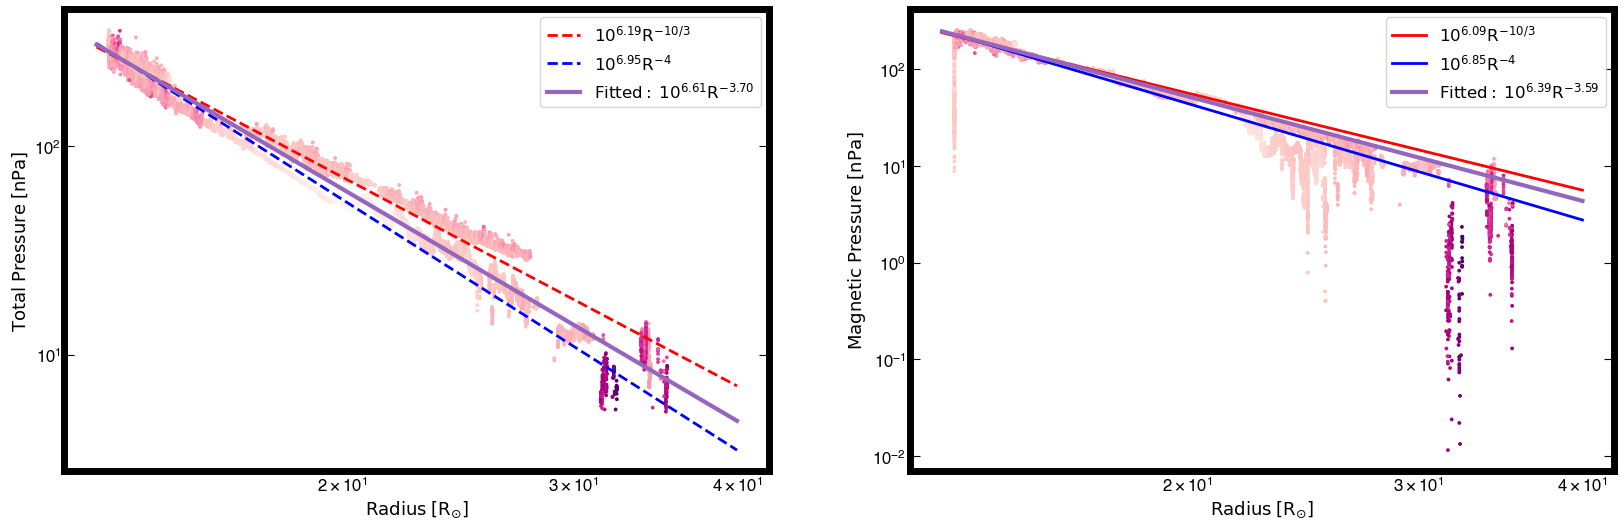

In [14]:

#### ------ RSun vs. Pressure ----- ####
fig, axs = plt.subplots(1, 2, figsize=[20,6], sharex='all')
x = np.linspace(13, 40)
i103 = (10**6.19)*x**(-10/3)
i4 = (10**6.95)*x**(-4)
fitt = (10**6.61)*(x**(-3.70))
### Total Pressure
ax = axs[0]
im = ax.scatter(Rsun.value, parker.Ptotal, c=parker.vr, cmap='RdPu', s=3)
ax.plot(x, i103, c='red', linewidth=2, linestyle='dashed', label=r'$\rm 10^{6.19} R^{-10/3}$')
ax.plot(x, i4, c='blue', linewidth=2, linestyle='dashed', label=r'$\rm 10^{6.95} R^{-4}$')
ax.plot(x, fitt, c='tab:purple', linewidth=3, label=r'$\rm Fitted: \;  10^{6.61} R^{-3.70}$')
ax.set(xlabel=r'$\rm Radius \; [R_{\odot}]$', ylabel=r'$\rm Total \; Pressure \; [nPa]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

### Magnetic Pressure
i103 = (10**6.09)*x**(-10/3)
i4 = (10**6.85)*x**(-4)
fitb = (10**6.39)*(x**(-3.59))
ax = axs[1]
im = ax.scatter(Rsun.value, parker.Pm/1e-9, c=parker.vr, cmap='RdPu', s=3)
ax.set(xlabel=r'$\rm Radius \; [R_{\odot}]$', ylabel=r'$\rm Magnetic \; Pressure \; [nPa]$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(x, i103, c='red', linewidth=2, label=r'$\rm 10^{6.09} R^{-10/3}$')
ax.plot(x, i4, c='blue', linewidth=2, label=r'$\rm 10^{6.85} R^{-4}$')
ax.plot(x, fitb, c='tab:purple', linewidth=3, label=r'$\rm Fitted: \; 10^{6.39} R^{-3.59}$')
ax.legend()

# Create Figure

- RTN Magnetic Field
- Pressure
- Expected Pressure
- Beta

/var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_77083/2518106561.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text.Te[text.Te > 200] = 0


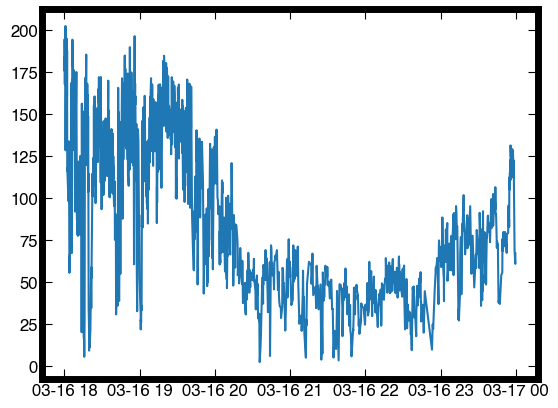

In [4]:
file = glob.glob(os.path.join(RES_DIR, 'parker20.csv'))
text = pd.read_csv(file[0])
text['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in text.Time]
flagNe = np.logical_and(pd.Timestamp('2023-03-16 18:00:00')<=text.Time, text.Time<=pd.Timestamp('2023-03-17 00:00:00'))
text.Te[text.Te > 200] = 0
plt.plot(text.Time[flagNe], text.Np[flagNe])

/var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_77083/105994243.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parker.Pe[flagNe] = test


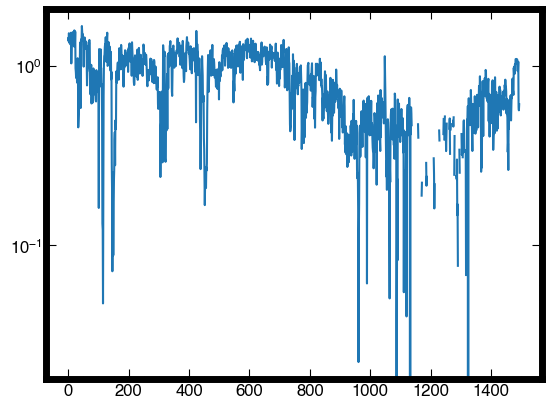

In [5]:
### CALCULATE ELECTRON PRESSURE IN MISSING GAP
from plasmapy.formulary import beta, magnetic_pressure, thermal_pressure, ion_sound_speed

flagNe = np.logical_and(pd.Timestamp('2023-03-16 18:00:00')<=text.Time, text.Time<=pd.Timestamp('2023-03-17 00:00:00'))
test = thermal_pressure(np.array(text.Te[flagNe])*u.eV, np.array(text.Np[flagNe])/u.cm**3).value
plt.plot(test/1e-9)
plt.yscale('log')
flagNe = np.logical_and(pd.Timestamp('2023-03-16 18:00:00')<=parker.Time, parker.Time<=pd.Timestamp('2023-03-17 00:00:00'))
parker.Pe[flagNe] = test

In [8]:
Rsun = (np.array(parker.rAU)*u.AU).to(u.Rsun)
parker['Ptotal'] = (parker.Pa + parker.Pp + parker.Pm + parker.Pe)/1e-9
parker['Pk'] = (parker.Pa + parker.Pp + parker.Pe)/1e-9
parker['Pap'] = (parker.Pa + parker.Pp)/1e-9

bin_size = pd.Timedelta(minutes=30)
parkerdownt = parker.resample(bin_size, closed='left', label='left', loffset=bin_size / 2).mean()
parkerdownt['Time'] = parkerdownt.index

/var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_77083/3425605479.py:7: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  parkerdownt = parker.resample(bin_size, closed='left', label='left', loffset=bin_size / 2).mean()
/var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_77083/3425605479.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  parkerdownt = parker.resample(bin_size, closed='left', label='left', loffset=bin_size / 2).mean()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


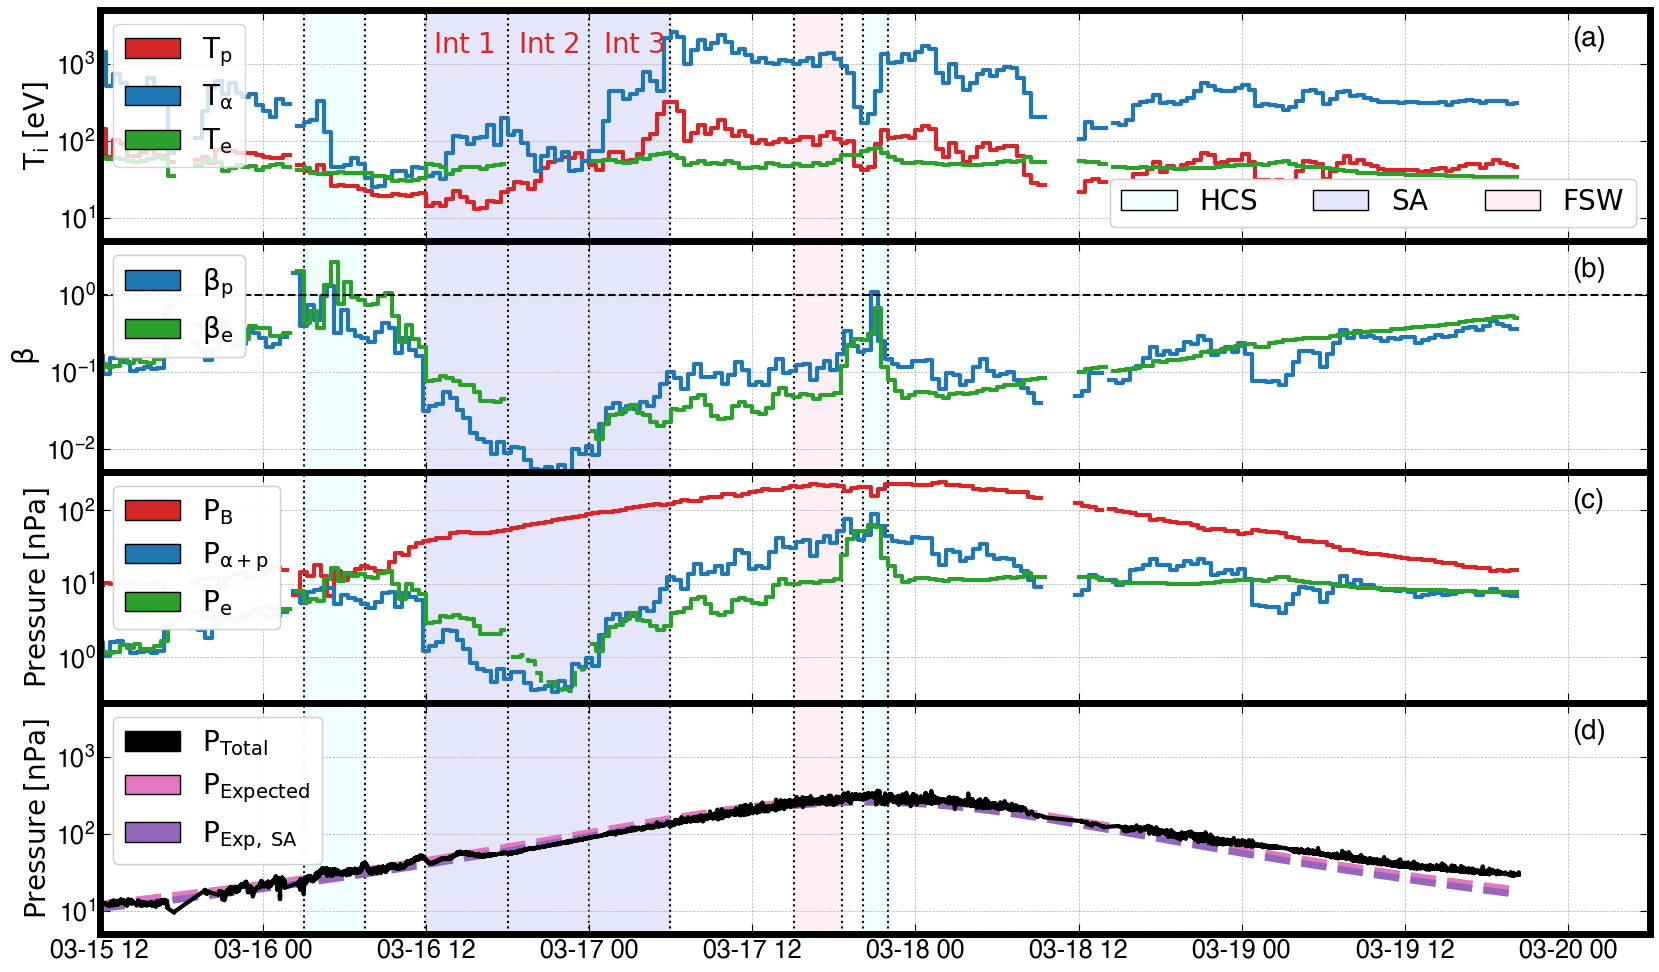

In [12]:
### PLOT SETUP
Rsun = (np.array(parker.rAU)*u.AU).to(u.Rsun)

ss=1
fig = plt.figure(figsize=(20, 12))
grid = plt.GridSpec(4, 1,wspace=0.05, hspace=0)

### LABELS
xlabel = r'$\rm Time$'
ylabels = [r'$\rm T_i \; [eV]$',
           r'$\rm \beta$',
            r'$\rm Pressure \; [nPa]$', 
            r'$\rm Pressure \; [nPa]$'
            ]

### EXPECTED PRESSURE
Pexpt = (10**6.61)*(Rsun.value**(-3.70))
Pexptslow = (10**6.61)*(Rsun.value**(-3.74))

### DEFINE DATA, LABELS, COLORMAPS
rcol='grey'
cr, ct, cn, cmag = ['tab:red', 'tab:blue', 'tab:green', 'k']
lw=3
lwp=5

##### ---------- PANEL ONE: TEMPERATURES  ---------- ######
ax = plt.subplot(grid[0, 0])
ax.step(parkerdownt.Time, parkerdownt.Tp, c=cr, where='mid', linewidth=lw, label=r'$\rm T_p$')
ax.step(parkerdownt.Time, parkerdownt.Ta, c=ct, where='mid', linewidth=lw, label=r'$\rm T_{\alpha}$')

# electron beta
flagNe = np.logical_and(pd.Timestamp('2023-03-15 00:00:00')<=parkerdownt.Time, parkerdownt.Time<=pd.Timestamp('2023-03-16 18:00:00'))
ax.step(parkerdownt.Time[flagNe], (parkerdownt.Te[flagNe]), where='mid', color=cn, linewidth=lw, label=r'$\rm N_{E}$', markersize=ss)
flagNe = np.logical_and(pd.Timestamp('2023-03-17 00:00:00')<=parkerdownt.Time, parkerdownt.Time<=pd.Timestamp('2023-03-20 00:00:00'))
ax.step(parkerdownt.Time[flagNe], (parkerdownt.Te[flagNe]), where='mid', color=cn, linewidth=lw, label=r'$\rm N_{E}$', markersize=ss)

ax.set_yscale('log')
ax.set_xticklabels([])
ax.set(ylim=(5e0, 5e3), yticks=([1e1, 1e2, 1e3]))

### LEGEND ###
R_patch = mpatches.Patch(facecolor=cr, edgecolor='k', label=r'$\rm T_{p}$')
T_patch = mpatches.Patch(facecolor=ct, edgecolor='k', label=r'$\rm T_{\alpha}$')
N_patch = mpatches.Patch(facecolor=cn, edgecolor='k', label=r'$\rm T_{e}$')
leg0 = ax.legend(handles=[R_patch, T_patch, N_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)

### REGIONS LEGEND
R_patch = mpatches.Patch(facecolor=hcol, edgecolor='k', label=r'$\rm HCS$')
T_patch = mpatches.Patch(facecolor=scol, edgecolor='k', label=r'$\rm SA$')
N_patch = mpatches.Patch(facecolor=fcol, edgecolor='k', label=r'$\rm FSW$')
leg1 = ax.legend(handles=[R_patch, T_patch, N_patch], loc='lower right', fontsize=20, ncol=3)
ax.add_artist(leg1)

##### ---------- PANEL TWO: PLASMA BETA  ---------- ######
ax = plt.subplot(grid[1, 0])
ax.step(parkerdownt.Time, parkerdownt.beta, c=ct, linewidth=lw, label=r'$\rm \beta_p$')
# electron beta
flagNe = np.logical_and(pd.Timestamp('2023-03-15 00:00:00')<=parkerdownt.Time, parkerdownt.Time<=pd.Timestamp('2023-03-16 18:00:00'))
ax.step(parkerdownt.Time[flagNe], (parkerdownt.betae[flagNe]), where='mid', color=cn, linewidth=lw, label=r'$\rm N_{E}$', markersize=ss)
flagNe = np.logical_and(pd.Timestamp('2023-03-17 00:00:00')<=parkerdownt.Time, parkerdownt.Time<=pd.Timestamp('2023-03-20 00:00:00'))
ax.step(parkerdownt.Time[flagNe], (parkerdownt.betae[flagNe]), where='mid', color=cn, linewidth=lw, label=r'$\rm N_{E}$', markersize=ss)

ax.axhline(1, color='k', linestyle='dashed') ## plasma beta
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set(ylim=(5e-3, 5e0), yticks=([1e-2, 1e-1, 1e0]))

### LEGEND ###
R_patch = mpatches.Patch(edgecolor='k', facecolor=ct, label=r'$\rm \beta_p$')
N_patch = mpatches.Patch(edgecolor='k', facecolor=cn, label=r'$\rm \beta_e$')
leg0 = ax.legend(handles=[R_patch, N_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)
# ax.set_title(r'$\rm Full \; Encounter$', fontsize=22)



##### ---------- PANEL THREE: PRESSURES  ---------- ######
ax = plt.subplot(grid[2, 0])
ax.step(parkerdownt.Time, parkerdownt.Pm/1e-9, c=cr, linewidth=lw, label=r'$\rm P_{B}$')
ax.step(parkerdownt.Time, (parkerdownt.Pa + parkerdownt.Pp)/1e-9, c=ct, linewidth=lw, label=r'$\rm P_{\alpha + p}$') #, s=ss)
# electron pressure -- fix for bad observation
flagNe = np.logical_and(pd.Timestamp('2023-03-15 00:00:00')<=parkerdownt.Time, parkerdownt.Time<=pd.Timestamp('2023-03-16 18:00:00'))
ax.step(parkerdownt.Time[flagNe], (parkerdownt.Pe[flagNe])/1e-9, where='mid', color=cn, linewidth=lw, label=r'$\rm N_{E}$', markersize=ss)
flagNe = np.logical_and(pd.Timestamp('2023-03-17 00:00:00')<=parkerdownt.Time, parkerdownt.Time<=pd.Timestamp('2023-03-20 00:00:00'))
ax.step(parkerdownt.Time[flagNe], (parkerdownt.Pe[flagNe])/1e-9, where='mid', color=cn, linewidth=lw, label=r'$\rm N_{E}$', markersize=ss)
flagNe = np.logical_and(pd.Timestamp('2023-03-16 18:00:00')<=parkerdownt.Time, parkerdownt.Time<=pd.Timestamp('2023-03-17 00:00:00'))
ax.step(parkerdownt.Time[flagNe], (parkerdownt.Pe[flagNe])/1e-9, where='mid', color=cn, linewidth=lw, label=r'$\rm N_{E}$', markersize=ss, linestyle='dashed')

ax.set_yscale('log')
ax.set_xticklabels([])

### LEGEND ###
R_patch = mpatches.Patch(edgecolor='k', facecolor=cr, label=r'$\rm P_{B}$')
T_patch = mpatches.Patch(edgecolor='k', facecolor=ct, label=r'$\rm P_{\alpha + p}$')
N_patch = mpatches.Patch(edgecolor='k', facecolor=cn, label=r'$\rm P_{e}$')
leg0 = ax.legend(handles=[R_patch, T_patch, N_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)


##### ---------- PANEL FOUR: TOTAL PRESSURE  ---------- ######
ax = plt.subplot(grid[3, 0])
ax.plot(parker.Time, parker.Ptotal, c=cmag, linewidth=lw, label=r'$\rm P_{Total}$', zorder=3)
ax.plot(parker.Time, Pexpt, c='tab:pink', linestyle='dashed', linewidth=lwp, label=r'$\rm P_{Expected}$')
ax.plot(parker.Time, Pexptslow, c='tab:purple', linestyle='dashed', linewidth=lwp, label=r'$\rm P_{Expected, \; Sub-Alfv\'enic}$')
ax.set_yscale('log')
ax.set(ylim=(5e0, 5e3), yticks=([1e1, 1e2, 1e3]))

### LEGEND ###
M_patch = mpatches.Patch(edgecolor='k', facecolor=cmag, label=r'$\rm P_{Total}$')
T_patch = mpatches.Patch(edgecolor='k', facecolor='tab:pink', label=r'$\rm P_{Expected}$')
N_patch = mpatches.Patch(edgecolor='k', facecolor='tab:purple', label=r'$\rm P_{Exp, \; SA}$')
leg0 = ax.legend(handles=[M_patch, T_patch, N_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)


##### ---------- FULL DATA  ---------- ######
panel_labels = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate([plt.subplot(grid[0, 0]), plt.subplot(grid[1, 0]), plt.subplot(grid[2, 0]) , plt.subplot(grid[3, 0])]):
    ### ADD Y-LABEL
    ax.set_ylabel(ylabel=ylabels[i], fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18) 
    
    ### ADD X-LIMITS
    ax.set_xlim(pd.Timestamp('2023-03-15 12:00:00'), pd.Timestamp('2023-03-20 06:00:00'))

    ### ADD THE GRID
    ax.grid(True, linestyle='--', linewidth=0.5)

    ### ADD REGIONS
    regions = [
        (parker[hhcs].Time.iloc[0], parker[hhcs].Time.iloc[-1], hcol),
        (parker[hhcs1].Time.iloc[0], parker[hhcs1].Time.iloc[-1], hcol),
        (parker[slow].Time.iloc[0], parker[slow].Time.iloc[-1], scol),
        (parker[fast].Time.iloc[0], parker[fast].Time.iloc[-1], fcol)
    ]

    lines = [
        parker[hhcs].Time.iloc[0],
        parker[hhcs].Time.iloc[-1],
        parker[hhcs1].Time.iloc[0],
        parker[hhcs1].Time.iloc[-1],
        parker[slow].Time.iloc[0],
        parker[slow].Time.iloc[-1],
        parker[fast].Time.iloc[0],
        parker[fast].Time.iloc[-1],
        pd.Timestamp('2023-03-16 18:00'),
        pd.Timestamp('2023-03-17 00:00')
    ]

    ### PLOT LINES AND REGIONS
    for line in lines:
        ax.axvline(line, color='k', linestyle='dotted', zorder=-2)

    for region in regions:
        ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

    ### ADD PANEL LABELS
    ax.text(0.95, 0.93, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# ##### ---------- PANEL FOUR: PLASMA BETA -- ZOOM  ---------- ######
# ax = plt.subplot(grid[0, 1])
# ax.step(parkerdownt.Time, parkerdownt.beta, c=cr, linewidth=lw, label=r'$\rm \beta_p$')
# ax.step(parkerdownt.Time, parkerdownt.betae, c=cn, linewidth=lw, label=r'$\rm \beta_E$')
# ax.axhline(1, color='k', linestyle='dashed') ## plasma beta
# ax.set_yscale('log')
# ax.set(ylim=(5e-3, 5e0), yticks=([1e-2, 1e-1, 1e0]))
# ax.set_xticklabels([])
# ax.set_title(r'$\rm Sub-Alfv\'enic \; Period$', fontsize=22)

# ##### ---------- PANEL FIVE: PRESSURES -- ZOOM  ---------- ######
# ax = plt.subplot(grid[1, 1])
# ax.step(parkerdownt.Time, parkerdownt.Pm/1e-9, c=cr, linewidth=lw, label=r'$\rm P_{B}$')
# ax.step(parkerdownt.Time, (parkerdownt.Pa + parkerdownt.Pp)/1e-9, c=ct, linewidth=lw, label=r'$\rm P_{\alpha + p}$')
# ax.step(parkerdownt.Time, (parkerdownt.Pe)/1e-9, c=cn, linewidth=lw, label=r'$\rm P_{e}$')
# ax.set_yscale('log')
# ax.set_xticklabels([])
# # ax.sharey(plt.subplot(grid[1, 0]))

# ##### ---------- PANEL SIX: TOTAL PRESSURE -- ZOOM  ---------- ######
# ax = plt.subplot(grid[2, 1])
# ax.plot(parker.Time, parker.Ptotal, c=cmag, linewidth=lw, label=r'$\rm P_{Total}$', zorder=10)
# ax.plot(parker.Time, Pexptslow, c='tab:purple', linestyle='dashed', linewidth=lwp, label=r'$\rm P_{Expected}$')
# ax.set_yscale('log')
# ax.set(ylim=(5e0, 5e3), yticks=([1e1, 1e2, 1e3]))

# panel_labels = ['(d)', '(e)', '(f)', '(g)', '(h)']
# for i, ax in enumerate([plt.subplot(grid[0, 1]), plt.subplot(grid[1, 1]), plt.subplot(grid[2, 1])]): #, plt.subplot(grid[3, 1])]):
#     ### ADD THE GRID
#     ax.grid(True, linestyle='--', linewidth=0.5)
#     ax.xaxis.set_minor_locator(ticker.NullLocator())

#     ### ADD X-LIMITS
#     ax.tick_params(axis='both', which='major', labelsize=18) 
#     ax.set_xlim(parker[slow].Time.iloc[0], parker[slow].Time.iloc[-1])
#     ax.set_xticks([pd.Timestamp('2023-03-16 12:00:00'), pd.Timestamp('2023-03-16 16:00:00'), pd.Timestamp('2023-03-16 20:00:00'),
#                    pd.Timestamp('2023-03-17 00:00:00'), pd.Timestamp('2023-03-17 04:00:00')])
    
#     ### REMOVE TICK LABELS
#     ax.set_yticklabels([])

#     ### ADD PANEL LABELS
#     ax.text(0.93, 0.93, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

##### ---------- LABEL REGIONS OF INTEREST ---------- ######
ax = plt.subplot(grid[0, 0])
# ax.text(0.14, 0.96, r'$\rm HCS$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# ax.text(0.23, 0.96, r'$\rm Sub-Alfv\'enic$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# ax.text(0.44, 0.96, r'$\rm FSW$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# ax.text(0.485, 0.96, r'$\rm HCS$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# add interval labels 
ax.text(0.215, 0.90, r'$\rm Int \; 1$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left', color='tab:red')
ax.text(0.27, 0.90, r'$\rm Int \; 2$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left', color='tab:red')
ax.text(0.325, 0.90, r'$\rm Int \; 3$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left', color='tab:red')

### SAVE FIGURE ###
plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'fig2.png')), bbox_inches='tight')
plt.savefig(os.path.realpath(os.path.join(EPS_DIR, 'fig2.eps')), bbox_inches='tight')

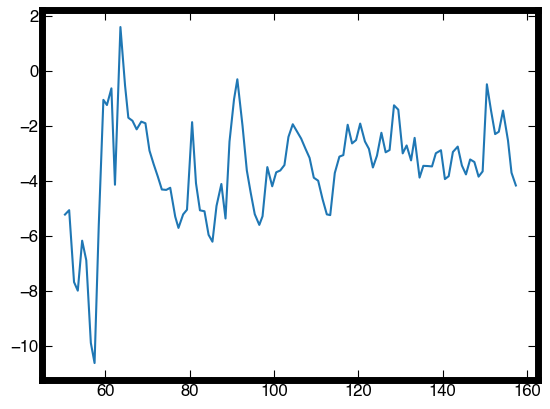

In [15]:

plt.plot(winddownl.sslon, winddownl.Br)


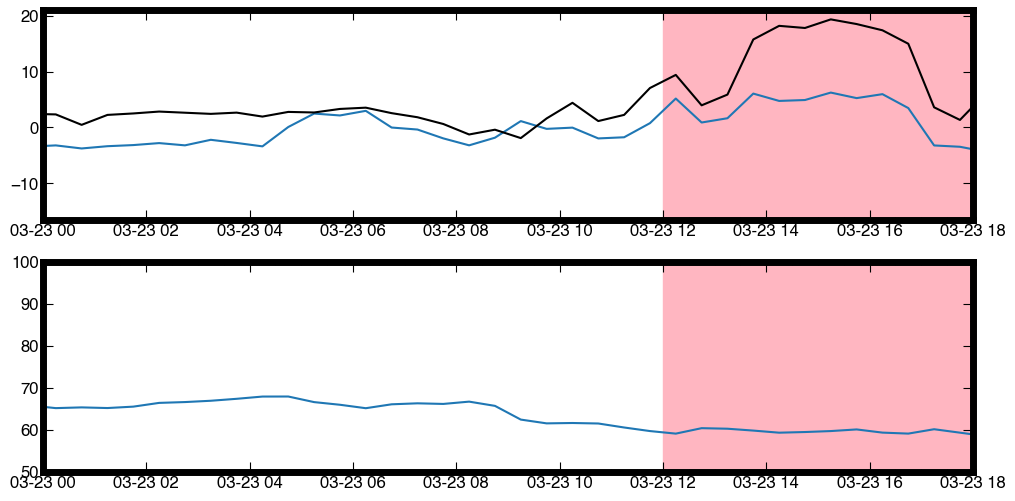

In [32]:
fig, axs = plt.subplots(2, figsize=(12, 6))
axs[0].plot(winddownt.Time, wind.Br)
axs[0].plot(winddownt.Time, winddownt.Bt, c='k')
axs[0].plot(winddownt.Time, winddownt.Bn, c='b')
axs[0].plot(winddownt.Time, winddownt.B, c='r')
axs[1].plot(winddownt.Time, winddownt.vr)
axs[1].plot(winddownt.Time, winddownt.vt, c='k')
axs[1].plot(winddownt.Time, winddownt.vn, c='b')
axs[1].plot(winddownt.Time, winddownt.B, c='r')
# axs[1].set_ylim(50, 100)
for ax in axs:
    ax.set_xlim(pd.Timestamp('2023-03-23'), pd.Timestamp('2023-03-24 00:00'))
    ax.axvspan(pd.Timestamp('2023-03-23 12:00'), pd.Timestamp('2023-03-23 18:00'), color='lightpink', zorder=-10)

In [33]:
wind.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Time', 'vr', 'vt', 'vn', 'Np', 'Tp',
       'vre', 'vte', 'vne', 'Ne', 'Te', 'Br', 'Bt', 'Bn', 'B', 'sigmac',
       'sigmar', 'vA', 'Zp', 'Zm', 'deltav', 'deltab', 'MA', 'betap', 'betae',
       'beta', 'Pm', 'Pp', 'lon', 'lat', 'rAU', 'sslon', 'sslat', 'ssrAU',
       'BrR2', 'NpR2', 'NeR2', 'bins'],
      dtype='object')

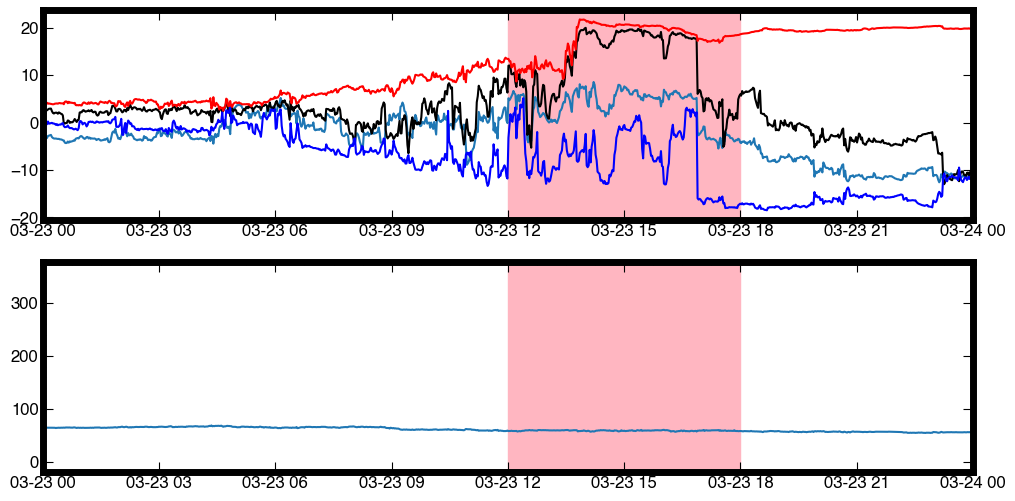

In [36]:
fig, axs = plt.subplots(2, figsize=(12, 6))
axs[0].plot(wind.Time, wind.Br)
axs[0].plot(wind.Time, wind.Bt, c='k')
axs[0].plot(wind.Time, wind.Bn, c='b')
axs[0].plot(wind.Time, wind.B, c='r')
# axs[1].plot(wind.Time, wind.vr)
# axs[1].plot(wind.Time, wind.vt, c='k')
# axs[1].plot(wind.Time, wind.vn, c='b')
# axs[1].plot(wind.Time, np.sqrt(wind.vn**2 + wind.vt**2 + wind.vr**2), c='r')
axs[1].plot(wind.Time, wind.sslon)
# axs[1].set_ylim(50, 100)
for ax in axs:
    ax.set_xlim(pd.Timestamp('2023-03-23'), pd.Timestamp('2023-03-24 00:00'))
    ax.axvspan(pd.Timestamp('2023-03-23 12:00'), pd.Timestamp('2023-03-23 18:00'), color='lightpink', zorder=-10)

## 